<a href="https://colab.research.google.com/github/isaisa002/COEN432-A2/blob/main/COEN432_Assignment2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Assignment 2: RNA Secondary Structure Prediction with CNNs

**Name:** Chrisdonia Isabelle Charles

**Student ID:** 40212996

## 1. Introduction & Objectives

Welcome to the second assignment! The goal of this assignment is not to build a state-of-the-art model, but to walk you through the complete pipeline of a deep learning project in bioinformatics. You will learn to process biological sequence data, convert it into a format suitable for neural networks, build a basic CNN model, and critically analyze its results.

### Core Learning Objectives:
1.  Understand and process standard bioinformatics data formats (FASTA and dot-bracket notation).
2.  Master data encoding techniques for sequences (One-hot encoding) and structures (Contact Maps).
3.  Design and implement a basic 2D CNN for a non-image task.
4.  Establish a complete machine learning pipeline: training, validation, and testing.
5.  Learn to use appropriate evaluation metrics (like F1-score) for imbalanced datasets.
6.  Visualize and critically analyze model predictions.

## Part 1: Data Exploration and Preprocessing (35%)

This is the **core** part of the assignment. You will be working with the bpRNA-1m dataset.

### 1.1 Setup and Imports

Let's start by importing the necessary libraries.

In [ ]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
import pandas as pd
from tqdm import tqdm
from sklearn.metrics import roc_auc_score


### 1.2 Data Loading and Parsing

Download the `.csv` files from moodle or direct mount it though google drive. (`TR0.csv`, `VL0.csv`, `TS0.csv`)

In [ ]:
import csv


def load_data_from_csv(file_path):
    """
    Loads sequence and structure data from a CSV file.
    Tries to be robust to variations in column names (e.g., 'sequence', 'seq', 'dot_bracket',
    'dotbracket', 'structure', etc.).

    Returns:
        list of tuples: A list where each tuple contains (sequence, dot_bracket_structure).
    """
    data_tuples = []

    with open(file_path, 'r', newline='', encoding='utf-8', errors='ignore') as csvfile:
        reader = csv.DictReader(csvfile)
        if reader.fieldnames is None:
            return data_tuples

        # Helper to find a column name from candidates (match substring in lowercase)
        def find_key(fieldnames, candidates):
            for fname in fieldnames:
                lf = fname.lower().strip()
                for c in candidates:
                    if c in lf:
                        return fname
            return None

        seq_candidates = ['sequence', 'seq', 'rna_sequence', 'nucleotide']
        struct_candidates = ['dot_bracket', 'dotbracket', 'dot', 'bracket', 'structure', 'dot-bracket', 'dot bracket']

        seq_key = find_key(reader.fieldnames, seq_candidates)
        struct_key = find_key(reader.fieldnames, struct_candidates)

        # Fallback heuristics
        if seq_key is None and len(reader.fieldnames) >= 1:
            seq_key = reader.fieldnames[0]
        if struct_key is None:
            # Prefer a different column than seq_key if possible
            for fname in reader.fieldnames:
                if fname != seq_key:
                    struct_key = fname
                    break

        if seq_key is None or struct_key is None:
            raise ValueError(f"Could not determine sequence/structure columns. Available columns: {reader.fieldnames}")

        for row in reader:
            sequence = row.get(seq_key, "") or ""
            structure = row.get(struct_key, "") or ""
            data_tuples.append((sequence, structure))

    return data_tuples

# TODO: Specify the paths to your CSV dataset files
# For example: "./TR0.csv"
train_path = r"C:\Users\isach\Downloads\UNI\5th year\1- Fall 2025\COEN 432 - Machine Learning\A2\COEN432-A2\TR0.csv"
val_path = r"C:\Users\isach\Downloads\UNI\5th year\1- Fall 2025\COEN 432 - Machine Learning\A2\COEN432-A2\VL0.csv"
test_path = r"C:\Users\isach\Downloads\UNI\5th year\1- Fall 2025\COEN 432 - Machine Learning\A2\COEN432-A2\TS0.csv"

train_data = load_data_from_csv(train_path)
val_data = load_data_from_csv(val_path)
test_data = load_data_from_csv(test_path)

print(f"Found {len(train_data)} training samples.")
print(f"Found {len(val_data)} validation samples.")
print(f"Found {len(test_data)} test samples.")

Found 10597 training samples.
Found 1273 validation samples.
Found 1275 test samples.


### 1.3 Data Encoding

Now, we need to convert the raw text data into numerical tensors that our model can understand.

**Input Encoding:** Convert the RNA sequence (A, C, G, U, and sometimes other characters) into a one-hot encoded matrix.

**Output Encoding:** Convert the dot-bracket notation into a 2D **contact map**. This is a symmetric `L x L` matrix where `M[i, j] = 1` if bases `i` and `j` are paired, and `0` otherwise.


In [ ]:
def one_hot_encode(sequence, max_len):
    """
    One-hot encodes an RNA sequence using efficient vectorized operations.
    """
    # TODO: Implement the one-hot encoding logic.
    # 1. Define a mapping from nucleotide to index (e.g., A->0, C->1, G->2, U->3).
    #    Handle any non-standard characters.
    nucleotide_to_index = {'A': 0, 'C': 1, 'G': 2, 'U': 3}
    
    # 2. Create a zero matrix of shape (max_len, 4).
    encoded = np.zeros((max_len, 4), dtype=np.float32)
    
    # 3. Truncate or pad the sequence to max_len -- sequence is longer than max_len ? truncate it -- sequence is shorter than max_len ? fill with zeros 
    sequence_truncated = sequence[:max_len]
    
    # 4. Fill the matrix based on the sequence using vectorized operations 
    # Convert sequence to uppercase and get indices
    seq_upper = sequence_truncated.upper()
    
    # Map nucleotides to indices, invalid nucleotides get -1 (will be ignored)
    indices = np.array([nucleotide_to_index.get(nucleotide, -1) for nucleotide in seq_upper])
    
    # Create row indices for valid nucleotides
    valid_positions = indices != -1
    row_indices = np.arange(len(indices))[valid_positions]
    col_indices = indices[valid_positions]
    
    # Use advanced indexing to set all ones at once
    if len(row_indices) > 0:
        encoded[row_indices, col_indices] = 1.0

    return encoded


def create_contact_map(dot_bracket, max_len):
    """
    Creates a contact map from a dot-bracket string.
    """
    # TODO: Implement the contact map creation logic.
    
    # 1. Truncate or pad the dot_bracket string to max_len
    dot_bracket_truncated = dot_bracket[:max_len]
    
    # 2. Create a zero matrix of shape (max_len, max_len)
    contact_map = np.zeros((max_len, max_len), dtype=np.float32)
    
    # 3. Use a stack to find matching parentheses '()' or brackets '[]', etc.
    # Stack to store (index, bracket_type) pairs using LIFO approach
    stack = []
    
    # Set to store paired indices for O(1) lookup
    paired_indices = set()
    
    # Define matching bracket pairs
    opening_brackets = {'(', '[', '{', '<'}
    bracket_pairs = {'(': ')', '[': ']', '{': '}', '<': '>'}
    
    # Loop through the dot-bracket string
    for i, char in enumerate(dot_bracket_truncated):
        match char:
            case '(' | '[' | '{' | '<':
                # Opening bracket: push index and bracket type onto stack
                stack.append((i, char))
            case ')' | ']' | '}' | '>':
                # Closing bracket: find matching opening bracket
                if stack:
                    # Pop the last opening bracket (LIFO)
                    opening_index, opening_char = stack.pop()
                    
                    # Verify bracket types match
                    if bracket_pairs.get(opening_char) == char:
                        # 4. For each pair of indices (i, j) that form a bond, set matrix[i, j] = 1 and matrix[j, i] = 1
                        contact_map[opening_index, i] = 1.0
                        contact_map[i, opening_index] = 1.0
                        
                        # Store paired indices in set for fast lookup
                        paired_indices.add(opening_index)
                        paired_indices.add(i)
            case _:
                # Unpaired base ? contact map already initialized to zeros
                pass
    
    return contact_map

### 1.4 Creating a PyTorch Dataset

To efficiently load data in batches, we'll use PyTorch's `Dataset` and `DataLoader` classes. You'll need to implement a custom `Dataset` that applies the encoding transformations.

In [1]:
class RNADataset(Dataset):
    """
    Custom PyTorch Dataset for RNA sequences and secondary structures.
    Performs one-hot encoding and contact map creation
    """
    def __init__(self, data, max_len):
        """
        Initialize the dataset.
        Args:
            data: List of (sequence, structure) tuples
            max_len: Maximum sequence length for padding/truncation
        """
        self.data = data
        self.max_len = max_len

    def __len__(self):
        """Return total number of samples in the dataset."""
        return len(self.data)

    def __getitem__(self, idx):
        """
        Retrieve and process a single sample.
        Perform PROCESSING: transforms raw data into numerical tensors suitable for the model.
        
        Args:
            idx: Index of the sample to retrieve
            
        Returns:
            Tuple of (input_tensor, target_tensor) where:
                - input_tensor: One-hot encoded sequence (X)
                - target_tensor: Contact map (Y)
        """
        # 1. Get sequence and structure at index idx
        sequence, structure = self.data[idx]
        
        # 2. One-hot encode the sequence (input X)
        encoded_sequence = one_hot_encode(sequence, self.max_len)
        
        # 3. Create contact map for the structure (target Y)
        contact_map = create_contact_map(structure, self.max_len)
        
        # 4. Convert to PyTorch tensors (normalized float32 in range [0,1])
        input_tensor = torch.from_numpy(encoded_sequence).float()
        target_tensor = torch.from_numpy(contact_map).float()
        
        return input_tensor, target_tensor


# Step 1: Define hyperparameters
# MAX_LEN=340: Chosen to avoid truncating most sequences
# BATCH_SIZE=16: Reduced from typical 32 to accommodate larger 340x340 contact maps
MAX_LEN = 340  
BATCH_SIZE = 16  

print(f"Dataset Configuration:")
print(f"  MAX_LEN: {MAX_LEN}")
print(f"  BATCH_SIZE: {BATCH_SIZE}")


# Step 2: Instantiate Dataset objects (Holdout Method - 3 non-overlapping splits)
print(f"\nCreating Dataset instances")
train_dataset = RNADataset(train_data, MAX_LEN)
val_dataset = RNADataset(val_data, MAX_LEN)
test_dataset = RNADataset(test_data, MAX_LEN)

print(f"  Training samples: {len(train_dataset)}")
print(f"  Validation samples: {len(val_dataset)}")
print(f"  Test samples: {len(test_dataset)}")


# Step 3: Create DataLoader instances with BATCHING, SHUFFLING, and parallel processing
print(f"\nCreating DataLoader instances")


train_loader = DataLoader(
    train_dataset,
    batch_size=BATCH_SIZE, # BATCHING: Group samples into mini-batches
    shuffle=True,           # SHUFFLING: Randomize for training to prevent model from learning data order
    num_workers=0,
    pin_memory=True,        # use GPU 
    drop_last=False         # Keep incomplete final batch
)

val_loader = DataLoader(
    val_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False,          # NO SHUFFLING: Maintain order for unbiased evaluation
    num_workers=0,
    pin_memory=True
)

test_loader = DataLoader(
    test_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False,          # NO SHUFFLING: Maintain order for final evaluation
    num_workers=0,
    pin_memory=True
)

print(f"  Train batches: {len(train_loader)}")
print(f"  Validation batches: {len(val_loader)}")
print(f"  Test batches: {len(test_loader)}")



NameError: name 'Dataset' is not defined

---
## Part 2: Model Implementation (20%)

Now, let's build a simple 2D CNN to predict the contact map.

### 2.1 Model Architecture

Your task is to design a CNN. Since the input is 1D (`L x 4`) but the output is 2D (`L x L`), you need to expand the input's dimensionality. A common technique is to create an "outer product" or tiling of the input features to get an initial `L x L x C` tensor.

For example, for each position `(i, j)` in the `L x L` grid, the feature vector could be the concatenation of the one-hot vectors for base `i` and base `j`. This would create an `L x L x 8` input tensor.


In [ ]:
class RNAFoldingCNN(nn.Module):
    def __init__(self, input_channels=8):
        super(RNAFoldingCNN, self).__init__()
        # Convolutional block 1: learn local pairing patterns
        self.conv1 = nn.Conv2d(in_channels=input_channels, out_channels=32, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(32)
        self.relu1 = nn.ReLU()
        
        # Convolutional block 2: deeper features
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(64)
        self.relu2 = nn.ReLU()
        
        # Convolutional block 3: reduce channels, preserve spatial info
        self.conv3 = nn.Conv2d(in_channels=64, out_channels=32, kernel_size=3, padding=1)
        self.bn3 = nn.BatchNorm2d(32)
        self.relu3 = nn.ReLU()
        
        # Final 1x1 convolution: output contact probability map
        self.conv_out = nn.Conv2d(in_channels=32, out_channels=1, kernel_size=1)

    def forward(self, x_1d):
        # x_1d has shape (batch, max_len, 4)

        # Step 1: Expand the 1D input to a 2D feature map
        # Create an outer product representation where each position (i,j) contains features for both base i and base j
        batch_size = x_1d.shape[0]
        max_len = x_1d.shape[1]
        
        # Expand x_1d along dimension 1 to repeat for each j position
        x_2d_i = x_1d.unsqueeze(2).repeat(1, 1, max_len, 1)  # (batch, max_len, max_len, 4)
        
        # Expand x_1d along dimension 2 to repeat for each i position
        x_2d_j = x_1d.unsqueeze(1).repeat(1, max_len, 1, 1)  # (batch, max_len, max_len, 4)
        
        # Concatenate features from both bases (i and j) along the feature dimension
        x_2d = torch.cat([x_2d_i, x_2d_j], dim=-1)  # (batch, max_len, max_len, 8)
        
        # Permute to channels-first format for Conv2d: (batch, channels, height, width)
        x = x_2d.permute(0, 3, 1, 2)  # (batch, 8, max_len, max_len)

        # Step 2: Pass through convolutional blocks
        # Convolutional block 1: Conv2d → BatchNorm2d → ReLU
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu1(x)
        
        # Convolutional block 2: Conv2d → BatchNorm2d → ReLU
        x = self.conv2(x)
        x = self.bn2(x)
        x = self.relu2(x)
        
        # Convolutional block 3: Conv2d → BatchNorm2d → ReLU
        x = self.conv3(x)
        x = self.bn3(x)
        x = self.relu3(x)
        
        # Step 3: Final 1x1 convolution to get contact probability map
        x = self.conv_out(x)  # (batch, 1, max_len, max_len)
        
        # Step 4: Apply sigmoid activation to get probabilities in [0, 1]
        x = torch.sigmoid(x)
        
        # Step 5: Enforce symmetry (contact map must be symmetric across diagonal)
        # Add the matrix to its transpose and divide by 2
        x = x.squeeze(1)  # Remove channel dimension: (batch, max_len, max_len)
        x_symmetric = (x + x.transpose(1, 2)) / 2.0  # Average with transpose
        
        return x_symmetric

### 2.2 Architecture Explanation

**Model Architecture**

This model is a simple 2D Convolutional Neural Network (CNN) designed for RNA secondary structure prediction. The input is a 1D sequence (L x 4) that is expanded into a 2D representation (L x L x 8) using an outer product, so each position (i, j) contains features for both base i and base j. This allows the CNN to learn local pairing patterns between bases.

**Layer Structure:**
- **Input Expansion:** Converts the 1D sequence into a 2D feature map using concatenation of one-hot vectors for each base pair (i, j).
- **Convolutional Blocks:**
  - Three Conv2d layers with kernel size 3x3 and padding=1 to preserve spatial dimensions.
  - Each Conv2d is followed by BatchNorm2d for normalization and ReLU activation for non-linearity.
  - The number of channels increases then decreases (32 → 64 → 32) to learn complex and then refined features.
- **Output Layer:**
  - A final 1x1 Conv2d layer reduces the channels to 1, producing a contact probability map.
  - Sigmoid activation ensures output values are in [0, 1].
  - The output is made symmetric by averaging with its transpose, reflecting the fact that RNA base pairing is bidirectional.

**Design Choices & Rationale:**
- **No Pooling:** Pooling layers (like MaxPool2d) are omitted to maintain full spatial resolution, which is crucial for contact map prediction In fact, Pooling layers shrink the image while keeping the important information and here we want to keep all information
- **Batch Normalization:** Used after each Conv2d to stabilize and speed up training (see .txt: "Batch norm stabilizes training by normalizing layer outputs").
- **Activation:** ReLU is used for non-linearity so that the network learn non-linear patterns"
- **Symmetry Enforcement:** The contact map must be symmetric because if base i pairs with base j, then base j pairs with base i 

**References:**
- DeepLizard CNN PyTorch tutorial
- https://deeplizard.com/learn/video/gmBfb6LNnZs 
- https://deeplizard.com/learn/video/k4jY9L8H89U


---
## Part 3: Model Training and Evaluation (25%)

### 3.1 Setup for Training

Let's define the loss function, optimizer, and the evaluation metric (F1-score).

In [ ]:
#1. SET UP DEVICE

# Choose CPU or GPU for computation
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")


# 2. INSTANTIATE MODEL
# Create model using RNAFoldingCNN() and move it to the device
model = RNAFoldingCNN(input_channels=8)
model = model.to(device)
print(f"Model created and moved to {device}")
print(f"Total parameters: {sum(p.numel() for p in model.parameters()):,}")

# 3. DEFINE LOSS FUNCTION

# For binary contact map prediction, use Binary Cross-Entropy
loss_fn = nn.BCELoss()
print("Loss function: Binary Cross-Entropy (BCELoss)")


# 4. SET UP ADAM OPTIMIZER
# Adam optimizer
optimizer = optim.Adam(model.parameters(), lr=0.001)
print("Optimizer: Adam with learning rate 0.001")

#======5. METRICS: F1 AND RECALL=============
def calculate_f1_recall(y_pred, y_true, threshold=0.5):
    """
    Calculates F1 and Recall scores for binary classification.
    
    Args:
        y_pred: Predicted probabilities (PyTorch tensor)
        y_true: Ground truth labels (PyTorch tensor )
        threshold: Threshold for converting probabilities to binary predictions
    
    Returns:
        f1: F1 score
        recall: Recall score
      """
    from sklearn.metrics import f1_score, recall_score
    
    # Convert tensors to numpy
    if torch.is_tensor(y_pred):
        y_pred = y_pred.detach().cpu().numpy()
    if torch.is_tensor(y_true):
        y_true = y_true.detach().cpu().numpy()
    
    # Flatten arrays
    y_pred_flat = y_pred.flatten()
    y_true_flat = y_true.flatten()
    
    # Convert probabilities to binary predictions
    y_pred_bin = (y_pred_flat > threshold).astype(int)
    
    # Calculate F1 and Recall
    f1 = f1_score(y_true_flat, y_pred_bin, zero_division=0)
    recall = recall_score(y_true_flat, y_pred_bin, zero_division=0)
    
    return f1, recall

#=======================6. ROC CURVE AND AUC===================
def calculate_roc_auc(y_pred, y_true):
    """
    Calculates ROC curve and AUC score for binary classification.
    
        Args:
        y_pred: Predicted probabilities (PyTorch tensor)
        y_true: Ground truth labels (PyTorch tensor)
    
    Returns:
        fpr: False positive rates
        tpr: True positive rates
        auc: Area under the ROC curve
    
    Reference:
    """
    from sklearn.metrics import roc_curve, roc_auc_score
    
    # Convert tensors to numpy
    if torch.is_tensor(y_pred):
        y_pred = y_pred.detach().cpu().numpy()
    if torch.is_tensor(y_true):
        y_true = y_true.detach().cpu().numpy()
    
    # Flatten arrays
    y_pred_flat = y_pred.flatten()
    y_true_flat = y_true.flatten()
    
    # Calculate ROC curve and AUC
    try:
        fpr, tpr, thresholds = roc_curve(y_true_flat, y_pred_flat)
        auc = roc_auc_score(y_true_flat, y_pred_flat)
    except ValueError:
        # Handle edge cases (e.g., all predictions are the same class)
        fpr, tpr, auc = None, None, float('nan')
    
    return fpr, tpr, auc

print("\nAll setup complete! Ready for training.")

Using device: cuda


### 3.2 Training Loop

Now, write the main training loop. For each epoch, you should:
1.  Train the model on the training set.
2.  Evaluate the model on the validation set.
3.  Save the metrics (loss, F1 score) for plotting.
4.  Save the best model based on validation F1 score.


In [ ]:
# TODO: Implement the training and validation loop.
num_epochs = 10 # You might need more or fewer epochs.

train_losses = []
val_losses = []
val_f1_scores = []
val_recall_scores = []
val_auc_scores = []
best_val_f1 = -1




Epoch 1/10 [Validation]: 100%|██████████| 80/80 [00:02<00:00, 35.72it/s, auc=0.951, f1=0, loss=0.0198, recall=0]


Epoch 1/10 Summary | Train Loss: 0.0744 | Val Loss: 0.0212 | Val F1: 0.0045 | Val Recall: 0.0023 | Val AUC: 0.9304
  -> Saved new best model with F1 score: 0.0045


Epoch 2/10 [Validation]: 100%|██████████| 80/80 [00:02<00:00, 35.89it/s, auc=0.947, f1=0, loss=0.017, recall=0]


Epoch 2/10 Summary | Train Loss: 0.0190 | Val Loss: 0.0181 | Val F1: 0.0564 | Val Recall: 0.0307 | Val AUC: 0.9393
  -> Saved new best model with F1 score: 0.0564


Epoch 3/10 [Validation]: 100%|██████████| 80/80 [00:01<00:00, 53.04it/s, auc=0.951, f1=0, loss=0.0161, recall=0]


Epoch 3/10 Summary | Train Loss: 0.0177 | Val Loss: 0.0175 | Val F1: 0.0453 | Val Recall: 0.0242 | Val AUC: 0.9424


Epoch 4/10 [Validation]: 100%|██████████| 80/80 [00:01<00:00, 52.21it/s, auc=0.948, f1=0, loss=0.0164, recall=0]


Epoch 4/10 Summary | Train Loss: 0.0173 | Val Loss: 0.0173 | Val F1: 0.0799 | Val Recall: 0.0441 | Val AUC: 0.9431
  -> Saved new best model with F1 score: 0.0799


Epoch 5/10 [Validation]: 100%|██████████| 80/80 [00:02<00:00, 36.46it/s, auc=0.954, f1=0.025, loss=0.0164, recall=0.0135]


Epoch 5/10 Summary | Train Loss: 0.0171 | Val Loss: 0.0172 | Val F1: 0.1235 | Val Recall: 0.0714 | Val AUC: 0.9453
  -> Saved new best model with F1 score: 0.1235


Epoch 6/10 [Validation]: 100%|██████████| 80/80 [00:01<00:00, 53.36it/s, auc=0.954, f1=0, loss=0.016, recall=0]


Epoch 6/10 Summary | Train Loss: 0.0169 | Val Loss: 0.0171 | Val F1: 0.0768 | Val Recall: 0.0419 | Val AUC: 0.9445


Epoch 7/10 [Validation]: 100%|██████████| 80/80 [00:01<00:00, 52.48it/s, auc=0.956, f1=0, loss=0.0158, recall=0]


Epoch 7/10 Summary | Train Loss: 0.0168 | Val Loss: 0.0170 | Val F1: 0.1091 | Val Recall: 0.0616 | Val AUC: 0.9456


Epoch 8/10 [Validation]: 100%|██████████| 80/80 [00:01<00:00, 50.30it/s, auc=0.947, f1=0.0241, loss=0.0162, recall=0.0135]


Epoch 8/10 Summary | Train Loss: 0.0167 | Val Loss: 0.0170 | Val F1: 0.1467 | Val Recall: 0.0862 | Val AUC: 0.9456
  -> Saved new best model with F1 score: 0.1467


Epoch 9/10 [Validation]: 100%|██████████| 80/80 [00:02<00:00, 35.61it/s, auc=0.952, f1=0, loss=0.0163, recall=0]


Epoch 9/10 Summary | Train Loss: 0.0166 | Val Loss: 0.0169 | Val F1: 0.1354 | Val Recall: 0.0787 | Val AUC: 0.9457


Epoch 10/10 [Validation]: 100%|██████████| 80/80 [00:01<00:00, 51.23it/s, auc=0.948, f1=0, loss=0.0163, recall=0]

Epoch 10/10 Summary | Train Loss: 0.0165 | Val Loss: 0.0168 | Val F1: 0.1404 | Val Recall: 0.0814 | Val AUC: 0.9464


### 3.3 Plotting Metrics

Visualize the training process by plotting the loss and F1 score curves.


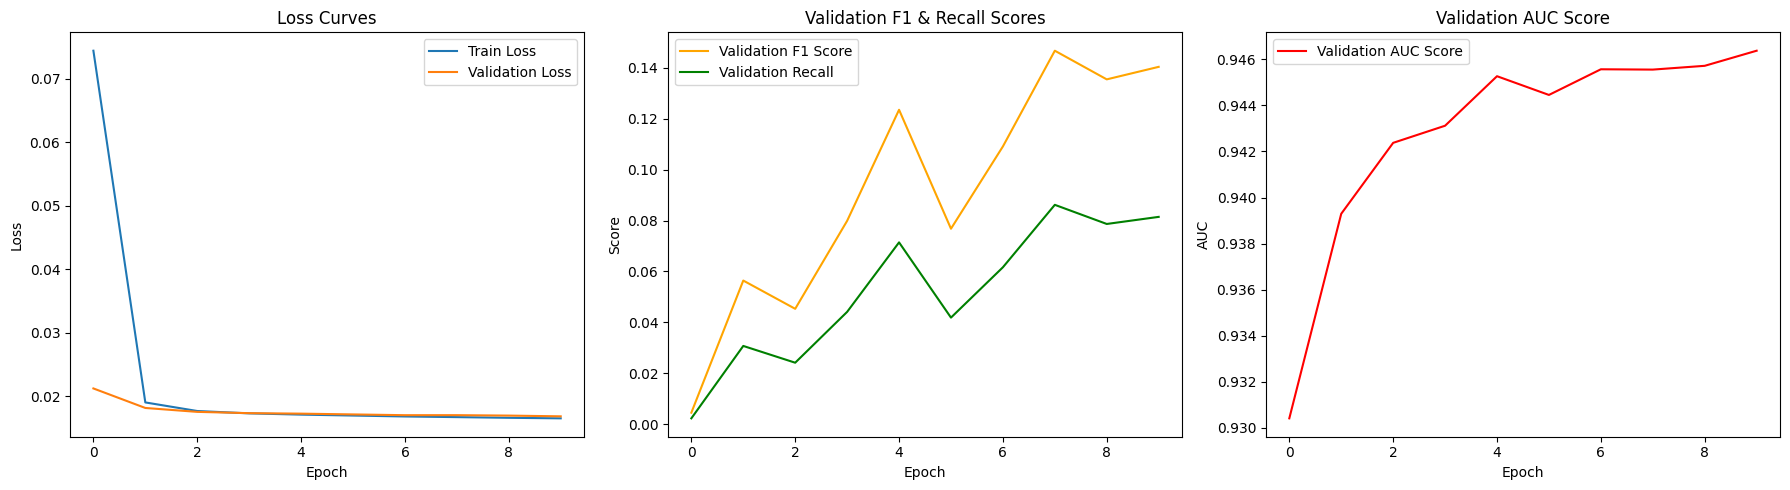

In [ ]:
# TODO: Plot the training and validation loss and metric curves.

# Loss Curves


# F1 and Recall Score Curves


# AUC Score Curve



---
## Part 4: Analysis and Reporting (20%)

### 4.1 Final Evaluation on Test Set

Load your best-performing model and evaluate its performance on the unseen test set.

It is normal that your simple CNN have a very low F1.

In [ ]:
# TODO: Load the best model and evaluate on the test set.





Testing: 100%|██████████| 80/80 [00:02<00:00, 36.92it/s]
Final Scores on the test set:
  -> F1 Score: 0.1335
  -> Recall:   0.0779
  -> AUC:      0.9479


### 4.2 Performance Analysis and Visualization

**TODO:** In this markdown cell, analyze your results.
- Did your model show signs of overfitting? How can you tell from the plots?
- Pick one or two examples from the test set and visualize the predicted contact map alongside the ground truth contact map. Analyze the results: what kind of structures does the model predict well? Where does it fail?
- **Imbalanced Data Analysis**: In this task, you may observe very high AUC scores (e.g., > 0.9) but relatively low F1 scores.
- Explain why this occurs. (Hint: In contact map prediction, which bases are most prevalent, paired bases (positive samples) or unpaired bases (negative samples)? How do AUC and F1 scores differ in measuring imbalanced data classification performance?)
- Propose the simplest parameter you can adjust to improve the F1 score and explain why this might be effective.

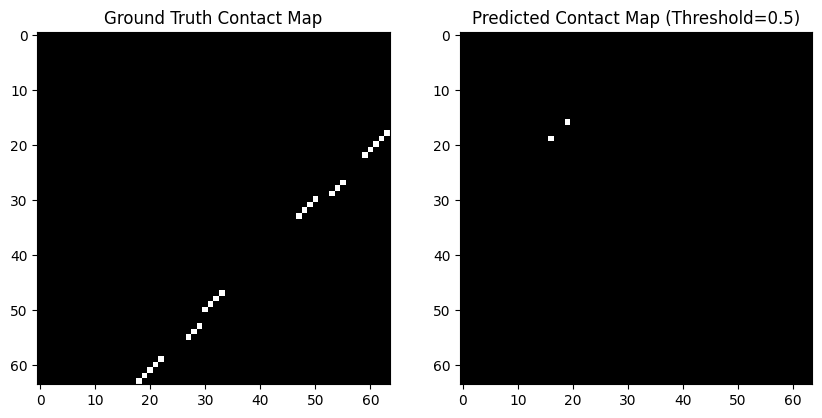

In [ ]:
# TODO: Write code to visualize one sample from the test set.
# 1. Get a batch from the test_loader.
# 2. Select one sample from the batch.
# 3. Get the model's prediction for that sample.
# 4. Use plt.imshow() to display the true contact map and the predicted one side-by-side.




### 4.3 Discussion and Conclusion

**TODO:** In this markdown cell, answer the following questions:
1.  What are the limitations of your simple CNN model? How well do you think it can capture long-range dependencies in the RNA sequence?
2.  If you had more time and computational resources, what are 2-3 specific improvements you would try to implement? (e.g., different model architectures, data augmentation, etc.)